In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import copy
import numpy as np
import time
import math
from torch import Tensor
from typing import List, Optional
from torch.optim import Optimizer

import importlib
importlib.import_module('FLDataset')
from FLDataset import load_dataset, getActualImgs
from utils import averageModels

In [2]:
#Function to do updates according to Adam's Formula
def adam(params: List[Tensor],grads: List[Tensor],exp_avgs: List[Tensor],exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],state_steps: List[int],*,beta1: float,beta2: float,lr: float,
         eps: float):
    
    for i, param in enumerate(params):

        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step

        #Configuring the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        
        denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

        step_size = lr / bias_correction1

        param.addcdiv_(exp_avg, denom, value=-step_size)

#Creating Adam Optimizer which overrides the step function.
class Adam(Optimizer):

    #Constructor with 4 parameters: LR, Beta rate and epsilon
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-7):

        defaults = dict(lr=lr, betas=betas, eps=eps)
        
        #Calling constructor of in-built PyTorch
        super(Adam, self).__init__(params, defaults)

    #THIS IS THE PART WHERE WE ARE IMPLEMENTING THE ADAM OPTIMIZER. 
    @torch.no_grad()
    def step(self):
        
        loss = None

        for group in self.param_groups:
            #Creating list to store various model parameters
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    grads.append(p.grad)

                    state = self.state[p]
                    if len(state) == 0:
                        state['step'] = 0
                        #Gradient values' exponential moving average
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        
                        #Squared gradient values' exponential moving average
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                       
                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    #Updating the number of steps for each param group
                    state['step'] += 1
                    
                    #Store and append the step after update
                    state_steps.append(state['step'])

            #Calling Adam's function to update parameters
            adam(params_with_grad, grads, exp_avgs,exp_avg_sqs,max_exp_avg_sqs,state_steps,
                   beta1=beta1,beta2=beta2,lr=group['lr'],eps=group['eps'])
            
        #return value of loss   
        return loss

In [3]:
#Class to define FL parameters
class Arguments():
    def __init__(self):
        self.images = 60000
        self.clients = 5
        self.rounds = 100
        self.epochs = 5
        self.local_batches = 128
        self.lr = 0.01
        self.C = 0.9
        self.drop_rate = 0.1
        self.torch_seed = 0
        self.log_interval = 100
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = False

args = Arguments()

use_cuda = args.use_cuda and torch.cuda.is_available()
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
## creating clients for FL

hook = sy.TorchHook(torch)
clients = []

for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})

In [5]:
# Download FashionMNIST manually using 'wget' then uncompress the file
!wget www.di.ens.fr/~lelarge/FashionMNIST.tar.gz
!tar -zxvf FashionMNIST.tar.gz

--2021-12-09 02:54:50--  http://www.di.ens.fr/~lelarge/FashionMNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/FashionMNIST.tar.gz [following]
--2021-12-09 02:54:51--  https://www.di.ens.fr/~lelarge/FashionMNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-12-09 02:54:52 ERROR 404: Not Found.

tar (child): FashionMNIST.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [6]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid)

In [7]:
for inx, client in enumerate(clients):
    trainset_ind_list = list(train_group[inx])
    client['trainset'] = getActualImgs(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getActualImgs(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.FashionMNIST('./', train=False, download=True, transform=transform)
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

global_train_dataset = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
global_train_loader = DataLoader(global_train_dataset, batch_size=args.local_batches, shuffle=True)

In [9]:
## creating neural net structure using pytorch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
## function to do updates during FL model rounds (calls step function)

def ClientUpdate(args, device, client):
    client['model'].train()
    client['model'].send(client['hook'])
    
    for epoch in range(1, args.epochs + 1):
        for batch_idx, (data, target) in enumerate(client['trainset']):
            data = data.send(client['hook'])
            target = target.send(client['hook'])
            
            data, target = data.to(device), target.to(device)
            client['optim'].zero_grad()
            output = client['model'](data)
            loss = F.nll_loss(output, target)
            loss.backward()
            client['optim'].step()
            
            if batch_idx % args.log_interval == 0:
                loss = loss.get() 
                print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    client['hook'].id,
                    epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                    100. * batch_idx / len(client['trainset']), loss))
                
    client['model'].get() 

In [11]:
## prints values periodically on testing data
def test(args, model, device, test_loader, name, isPrint):

    model.eval()   
    test_losss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_losss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_losss /= len(test_loader.dataset)
    
    if isPrint:
        print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_losss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
        test_loss.append(test_losss)
        test_acc.append(correct/len(test_loader.dataset))
        
    else:
        train_loss.append(test_losss)
        train_acc.append(correct/len(test_loader.dataset))
   
        
    #return loss_list

In [12]:
torch.manual_seed(args.torch_seed)
global_model = Net()

train_loss = []
test_loss = []
train_acc = []
test_acc = []

for client in clients:
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    client['optim'] = Adam(client['model'].parameters())
    
for fed_round in range(args.rounds):
    
    # number of selected clients
    m = int(max(args.C * args.clients, 1))

    # Selected devices
    np.random.seed(fed_round)
    selected_clients_inds = np.random.choice(range(len(clients)), m, replace=False)
    selected_clients = [clients[i] for i in selected_clients_inds]
    
    # Active devices
    np.random.seed(fed_round)
    active_clients_inds = np.random.choice(selected_clients_inds, int((1-args.drop_rate) * m), replace=False)
    active_clients = [clients[i] for i in active_clients_inds]
    
    # Training 
    for client in active_clients:
        ClientUpdate(args, device, client)
        
    # Averaging 
    global_model = averageModels(global_model, active_clients)
    
    # Testing the average model
    test(args, global_model, device, global_test_loader, 'Global',True)
    test(args, global_model, device, global_train_loader, 'Global',False)
    # Share the global model with the clients
    for client in clients:
        client['model'].load_state_dict(global_model.state_dict())
        
if (args.save_model):
    torch.save(global_model.state_dict(), "FedAvg.pt")

/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad


Model client2 Train Epoch: 1 [0/12032 (0%)]	Loss: 2.303588
Model client2 Train Epoch: 2 [0/12032 (0%)]	Loss: 0.494757
Model client2 Train Epoch: 3 [0/12032 (0%)]	Loss: 0.440894
Model client2 Train Epoch: 4 [0/12032 (0%)]	Loss: 0.340762
Model client2 Train Epoch: 5 [0/12032 (0%)]	Loss: 0.339608
Model client4 Train Epoch: 1 [0/12032 (0%)]	Loss: 2.328279
Model client4 Train Epoch: 2 [0/12032 (0%)]	Loss: 0.537373
Model client4 Train Epoch: 3 [0/12032 (0%)]	Loss: 0.487980
Model client4 Train Epoch: 4 [0/12032 (0%)]	Loss: 0.349624
Model client4 Train Epoch: 5 [0/12032 (0%)]	Loss: 0.345884
Model client1 Train Epoch: 1 [0/12032 (0%)]	Loss: 2.311100
Model client1 Train Epoch: 2 [0/12032 (0%)]	Loss: 0.442341
Model client1 Train Epoch: 3 [0/12032 (0%)]	Loss: 0.490997
Model client1 Train Epoch: 4 [0/12032 (0%)]	Loss: 0.500170
Model client1 Train Epoch: 5 [0/12032 (0%)]	Loss: 0.300523

Test set: Average loss for Global model: 1.4560, Accuracy: 8670/10000 (87%)

Model client1 Train Epoch: 1 [0/12032

In [13]:
train_loss, test_loss

([1.4489183291117351,
  1.3147098028818767,
  1.253915163675944,
  1.2012592283884684,
  1.188731842549642,
  1.168264548110962,
  1.170071420542399,
  1.1600374759674073,
  1.1368795247395833,
  1.1335091125488281,
  1.0901879288991292,
  1.1316636287689208,
  1.1082607758839924,
  1.1132725503285725,
  1.1380045004526773,
  1.1008274383544923,
  1.1004274487813315,
  1.0761584710439047,
  1.117350691350301,
  1.091252066040039,
  1.0794424282073976,
  1.081229476292928,
  1.1160388399759928,
  1.0973325199127197,
  1.0658118012746176,
  1.1082851641337077,
  1.0846132673899334,
  1.0718695593516032,
  1.0652637860616048,
  1.0715046696980794,
  1.0678856788635254,
  1.0961485560099284,
  1.047236520131429,
  1.0698381685892742,
  1.088001024246216,
  1.0757266638437908,
  1.0622573505401611,
  1.0827289302825929,
  1.077731437810262,
  1.0992659351348877,
  1.081123583730062,
  1.0335109034220378,
  1.1226092784881592,
  1.0521324303944906,
  1.0280480575561524,
  1.0659087271372478,

In [14]:
print(np.multiply(test_acc,100))

[86.7  88.11 88.98 88.97 88.82 89.9  89.26 90.17 89.77 89.11 89.9  89.76
 90.16 90.01 89.41 90.25 90.08 90.31 89.28 90.57 90.   90.32 90.46 89.9
 90.31 90.57 90.49 90.19 89.95 90.05 90.5  90.06 89.97 90.19 90.15 89.91
 90.08 89.62 89.89 90.45 90.11 90.16 90.35 90.24 90.32 89.99 90.41 89.92
 89.88 90.53 90.07 89.64 90.21 90.22 89.81 90.31 90.33 90.47 89.82 90.26
 90.1  90.37 90.27 90.17 90.71 89.47 89.71 90.4  90.04 90.38 89.51 90.08
 89.9  89.11 90.47 90.68 90.29 89.8  89.85 90.35 89.98 90.57 89.93 90.16
 90.45 89.93 90.55 90.13 90.81 90.43 90.24 89.87 90.44 90.59 90.19 89.85
 90.52 90.52 90.23 90.52]


In [15]:
x = [(i+1) for i in range(len(train_loss))]

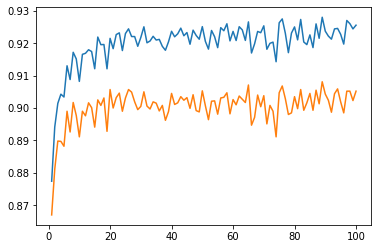

In [16]:
import matplotlib.pyplot as plt

#plt.plot(x,train_loss)
#plt.plot(x,test_loss)
plt.plot(x,train_acc)
plt.plot(x,test_acc)
plt.show()